In [1]:
import re
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt

In [2]:
path = 'next_word_prediction_dataset.csv'
sequence_length = 10
train_size = 0.9
batch_size = 32
embedding_dim = 32
hidden_dim = 512
num_layers = 2
learning_rate = 0.0001
num_epochs = 33

In [23]:
def load_and_preprocess_text(path, sequence_length):
    with open(path, mode = 'r', encoding = 'UTF-8') as f:
        text = f.read()
    text = text.lower()
    text = re.sub(r'[^a-z]', ' ', text)
    words = text.split()
    unique_tokens = sorted(set(words))
    word_to_idx = {word: i for i, word in enumerate(unique_tokens)}
    word_indices = [word_to_idx[word] for word in words]
    sequences = []
    for i in range(len(word_indices) - sequence_length):
        seq = word_indices[i:i + sequence_length]
        target = word_indices[i + sequence_length]
        sequences.append((seq, target))
    vocab_size = len(word_to_idx)
    return sequences, vocab_size, word_to_idx

In [24]:
sequences, vocab_size, word_to_idx = load_and_preprocess_text(path, sequence_length)

In [5]:
def create_dataset(sequences, train_size, batch_size):
    seq_train, seq_test = train_test_split(sequences, train_size = train_size, random_state = 42)
    X_train = [seq for seq, _ in seq_train]
    y_train = [target for _, target in seq_train]
    X_test = [seq for seq, _ in seq_test]
    y_test = [target for _, target in seq_test]
    X_train_tensor = torch.tensor(X_train, dtype = torch.long)
    y_train_tensor = torch.tensor(y_train, dtype = torch.long)
    X_test_tensor = torch.tensor(X_test, dtype = torch.long)
    y_test_tensor = torch.tensor(y_test, dtype = torch.long)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
    return train_loader, test_loader

In [6]:
train_loader, test_loader = create_dataset(sequences, train_size, batch_size)

In [7]:
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_dim):
        super(Model, self).__init__()
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        embedded = self.embedding(x)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(embedded, (h_0, c_0))
        out = out[:, -1, :]
        out = self.linear(out)
        return out

In [8]:
model = Model(vocab_size, embedding_dim, hidden_dim, num_layers, vocab_size)

In [9]:
def train_model(model, learning_rate, num_epochs, train_loader):
    criterion = CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    train_losses = []
    train_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item()
            _, predicted_labels = torch.max(pred, 1)
            correct_predictions += (predicted_labels == y).sum().item()
            total_samples += y.size(0)
            loss.backward()
            optimizer.step()
        train_accuracy = correct_predictions / total_samples
        avg_train_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {round(avg_train_loss, 2)}, Train Accuracy: {round(train_accuracy * 100, 2)}%')
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
    plt.figure(figsize = (16, 9))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label = 'Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(axis = 'y')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label = 'Train Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(axis = 'y')
    plt.show()

Epoch [1/33], Train Loss: 5.23, Train Accuracy: 13.28%
Epoch [2/33], Train Loss: 4.26, Train Accuracy: 27.11%
Epoch [3/33], Train Loss: 3.71, Train Accuracy: 33.52%
Epoch [4/33], Train Loss: 3.33, Train Accuracy: 37.13%
Epoch [5/33], Train Loss: 3.02, Train Accuracy: 41.44%
Epoch [6/33], Train Loss: 2.75, Train Accuracy: 45.38%
Epoch [7/33], Train Loss: 2.51, Train Accuracy: 49.24%
Epoch [8/33], Train Loss: 2.3, Train Accuracy: 53.11%
Epoch [9/33], Train Loss: 2.11, Train Accuracy: 56.44%
Epoch [10/33], Train Loss: 1.93, Train Accuracy: 59.61%
Epoch [11/33], Train Loss: 1.76, Train Accuracy: 62.64%
Epoch [12/33], Train Loss: 1.61, Train Accuracy: 65.39%
Epoch [13/33], Train Loss: 1.46, Train Accuracy: 68.29%
Epoch [14/33], Train Loss: 1.33, Train Accuracy: 71.07%
Epoch [15/33], Train Loss: 1.2, Train Accuracy: 73.85%
Epoch [16/33], Train Loss: 1.08, Train Accuracy: 76.54%
Epoch [17/33], Train Loss: 0.97, Train Accuracy: 79.33%
Epoch [18/33], Train Loss: 0.87, Train Accuracy: 81.81%
Epo

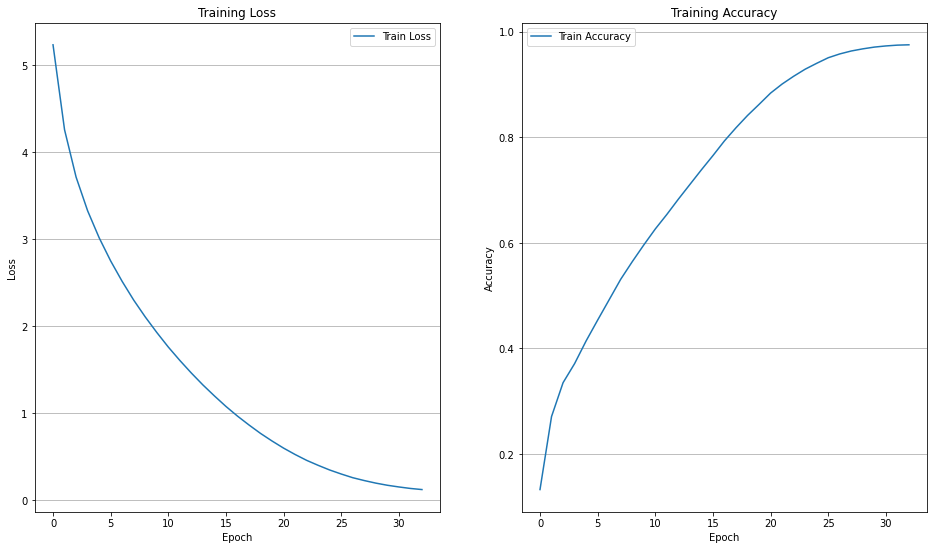

In [10]:
train_model(model, learning_rate, num_epochs, train_loader)

In [57]:
def predict_and_print(model, test_loader, word_to_idx):
    model.eval()
    for input_seq, targets in test_loader:
        for i in range(len(input_seq)):
            input_sentence = [word for idx in input_seq[i] for word, word_idx in word_to_idx.items() if idx == word_idx]
            target_word = [word for word, word_idx in word_to_idx.items() if targets[i].item() == word_idx][0]
            input_seq_tensor = torch.tensor(input_seq[i]).unsqueeze(0)
            with torch.no_grad():
                output_probs = torch.softmax(model(input_seq_tensor), dim = 1)
            _, predicted_index = torch.max(output_probs, 1)
            predicted_word = [word for word, idx in word_to_idx.items() if idx == predicted_index.item()][0]
            print(f"Sentence: {' '.join(input_sentence)}")
            print(f'Target: {target_word}')
            print(f'Prediction: {predicted_word}')
            print()
            if i == 9:
                break
        break

In [58]:
predict_and_print(model, test_loader, word_to_idx)

C:\Users\xMich\AppData\Local\Temp\ipykernel_19636\1033572604.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq_tensor = torch.tensor(input_seq[i]).unsqueeze(0)


Sentence: the depths of the darkest days embrace compassion for it
Target: is
Prediction: is

Sentence: turbulent seas of life let your empathy be the bridge
Target: that
Prediction: that

Sentence: of light in the world radiate joy and let it
Target: be
Prediction: be

Sentence: sunlight of positivity and watered by the rain of shared
Target: joys
Prediction: joys

Sentence: your acceptance will be the doorway to embracing what is
Target: believe
Prediction: believe

Sentence: our planet holds our planet s seashores are the thresholds
Target: of
Prediction: of

Sentence: it be the sanctuary within your heart radiate resilience and
Target: let
Prediction: let

Sentence: paints the horizon with hues of hope promising a day
Target: filled
Prediction: in

Sentence: and savor every moment as a precious gift of life
Target: have
Prediction: have

Sentence: the truest expression of your authentic self radiate confidence and
Target: let
Prediction: let

